# Instructions

We pull data from the Weights & Biases API and generate plots. Plots can be combined together into a multi-panel figures manually in Keynote for best control over arrangement (see `notebooks/paper/figure_panels.key`). The documentation for the Weights & Biases API function that fetches runs can be found [here](https://docs.wandb.ai/ref/python/public-api/api#runs), but you shouldn't need it if you use the helper functions below.

In [1]:
from typing import Literal, Any
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import wandb

# Style for making nice-looking paper plots with page-scale figure size units
sns.set(
    style="ticks",
    context="paper",
    rc={
        "font.size": 5,
        "axes.titlesize": 6,
        "axes.labelsize": 6,
        "axes.labelpad": 2,
        "xtick.labelsize": 4.5,
        "ytick.labelsize": 4.5,
        "legend.title_fontsize": 4.5,
        "legend.fontsize": 4.5,
        "legend.markerscale": 0.5,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.4,
        "xtick.major.width": 0.4,
        "ytick.major.width": 0.4,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,
        "xtick.minor.size": 1.5,
        "ytick.minor.size": 1.5,
        "xtick.minor.width": 0.2,
        "ytick.minor.width": 0.2,
        "figure.constrained_layout.use": True,
        "figure.dpi": 200,
    },
)

api = wandb.Api()

# Helper functions

In [2]:
# API querying
def get_run_performances(
    wandb_username: str,
    dataset: str,
    compare_across: list[str],
    comparison_metrics: list[str],
    filters: dict[str, Any],
    best_epoch: bool = True,
    mode: Literal["min", "max"] = "max",
    group_comparison: Literal["mean", "median"] = "mean",
    save_path: str = None,
    wandb_project: str = "Explicit-Implicit",
) -> pd.DataFrame:
    """Pulls data from the W&B API and returns a dataframe with either the best epoch performance for each run
    (when `best_epoch=True`) or the entire training trajectory across runs (when `best_epoch=False`).

    Args:
        wandb_username (str): Your W&B username.
        dataset (str): The identity of the task dataset you're querying (specified in the experiment config).
        compare_across (list[str]): List of attributes you want to compare across (e.g., ["model", "x_dim"]). Runs that have the same values for these attributes will be averaged over (hopefully just the seed!). These attributes are things that show up in the W&B config.
        comparison_metrics (list[str]): Metrics that you want to compare across runs. These are W&B metric names. Note that the first metric in the list is used for selecting the best epoch.
        filters (dict[str, Any]): W&B API filters used to select only a subset of runs. See code below for examples.
        best_epoch (bool, optional): Whether to select metrics only at the best epoch of each run, or return the entire training trajectory. Defaults to `True`.
        mode (Literal[&quot;min&quot;, &quot;max&quot;], optional): Whether smaller values are better for the metric (e.g., MSE) or larger values are (e.g., accuracy). Defaults to `"max"`.
        group_comparison (Literal[&quot;mean&quot;, &quot;median&quot;], optional): How to aggregate metrics within groups (e.g., across seeds for a given model) in order to pick the best epoch. Defaults to `"mean"`.
        save_path (str, optional): Optionally save the resulting dataframe. Note that if the file already exists, we retrieve its data and return that rather than querying the API. Defaults to `None`.
        wandb_project (str, optional): Name of the W&B project that the runs are in. Defaults to `"Explicit-Implicit"`.

    Returns:
        pd.DataFrame: Dataframe of results. It contains the run id, the `compare_across` values, the `comparison_metrics` metrics, and the epoch.
    """
    # If data has already been downloaded, don't make another API call
    if os.path.exists(save_path):
        print(f"Loading from cached file {save_path}...")
        data = pd.read_csv(save_path)
        data.replace("imlicit", "implicit", inplace=True)
        if "val/Accuracy/dataloader_idx_0" in list(data.columns.values):
            data["val/iid_Accuracy"] = data["val/Accuracy/dataloader_idx_0"]
            data["val/far_Accuracy"] = data["val/Accuracy/dataloader_idx_1"]
            data["val/wide_Accuracy"] = data["val/Accuracy/dataloader_idx_2"]
        return data

    if wandb_project == "mesa-opt-alchemy":
        alchemy_models = {
            "implicit": ["3udju5nr", "62rdiupe", "jk9sk4lq"],
            "explicit-transformer": ["qplfaq96", "zb3y9jca", "hhovr0xq"],
            "explicit-mlp": ["0xucpplr", "p9h6phu6", "79vvovut"],
        }
        data = []
        for model in alchemy_models.keys():
            runs = wandb.Api().runs(
                "leogagnon/mesa-opt-alchemy",
                filters={"name": {"$in": alchemy_models[model]}},
            )  # name instead of ID
            for run in runs:
                run_data = run.history(
                    samples=2000, x_axis="epoch", keys=comparison_metrics
                )
                run_data = run_data.assign(model=model)
                data.append(run_data)
        data = pd.concat(data)
    else:
        # Fetch all run data from the API
        runs = api.runs(
            f"{wandb_username}/{wandb_project}",
            filters={"config.dataset": dataset, **filters},
        )

        # Collect all of the run histories into a dataframe
        data = []
        for run in runs:
            comparison_vals = {k: run.config[k] for k in compare_across}
            run_data = run.history(
                samples=1000000, x_axis="epoch", keys=comparison_metrics
            )
            run_data = run_data.assign(run_id=run.id, **comparison_vals)
            data.append(run_data)
        data = pd.concat(data)

    # For each candidate, find the best performance over the course of training.
    # If there are multiple runs with the same `compare_across` values (e.g., different seeds),
    # then we take the best aggregate performance.
    if best_epoch:
        # fmt: off
        def best_epoch_results(group_data):
            epoch_agg = group_data.groupby("epoch")[comparison_metrics[0]].agg(group_comparison)
            best_epoch = epoch_agg.argmax() if mode == "max" else epoch_agg.argmin()
            best_epoch_data = group_data[group_data["epoch"] == best_epoch]
            return best_epoch_data
        data = data.groupby(compare_across).apply(best_epoch_results)
        data = data.reset_index(drop=True)
        # fmt: on

    data = data[["run_id", "epoch"] + compare_across + comparison_metrics]
    if save_path is not None:
        data.to_csv(save_path, index=False)
    return data


# Plotting


default_model_order = [
    "implicit",
    "explicit-transformer",
    "explicit-mlp",
    "explicit-known",
]
default_model_colours = {
    "implicit": sns.color_palette()[7],
    "explicit-transformer": sns.color_palette()[0],
    "explicit-mlp": sns.color_palette()[1],
    "explicit-known": sns.color_palette()[2],
}
default_model_short_names = {
    "implicit": "Implicit",
    "explicit-transformer": "Explicit - Transformer",
    "explicit-mlp": "Explicit - MLP",
    "explicit-known": "Explicit - Known",
}


def model_comparison_barplot(
    data: pd.DataFrame,
    metrics: str | list[str],
    metric_short_names: dict[str, str],
    metric_units: str,
    ax: plt.Axes,
    model_order: list[str] = default_model_order,
    model_colours: dict[str, Any] = default_model_colours,
    model_short_names: dict[str, str] = default_model_short_names,
    errorbar: str = "minmax",
    **kwargs,
) -> plt.Axes:
    """Convenience function to generate a barplot comparing models on a set of metrics. Metrics correspond to x-ticks, models correspond to bar colours.

    Args:
        data (pd.DataFrame): Dataframe of model performances, generally obtained from `get_run_performances()`.
        metrics (str | list[str]): Metrics along which to compare models. These will be x-ticks in the barplot.
        metric_short_names (dict[str, str]): Mapping from raw metric names to desired display names in the plot.
        metric_units (str): Units of the metrics, to be displayed on the y-axis.
        ax (plt.Axes): Matplotlib axes on which to plot.
        model_order (list[str], optional): Order in which to display models along the x-axis. Defaults to `default_model_order`.
        model_colours (dict[str, Any], optional): Colour for each model's bar. Defaults to `default_model_colours`.
        model_short_names (dict[str, str], optional): Display names for models in the legend. Defaults to `default_model_short_names`.
        errorbar (str, optional): How to construct the error bars when there are several samples per model and metric. Defaults to `"minmax"`.

    Returns:
        plt.Axes: The axes on which the plot was made.
    """
    # Check argument correctness
    models = data["model"].unique()
    for m in models:
        assert m in model_order and m in model_colours and m in model_short_names
    model_order = [m for m in model_order if m in models]
    if isinstance(metrics, str):
        metrics = [metrics]
    errorbar = (lambda x: (x.min(), x.max())) if errorbar == "minmax" else errorbar

    # Reorganize data
    data = data.rename(columns={m: metric_short_names[m] for m in metrics})
    data["model"] = data["model"].map(model_short_names)
    model_colours = [model_colours[m] for m in model_order]
    model_order = [model_short_names[m] for m in model_order]
    data = data.melt(
        id_vars=["model"],
        value_vars=metric_short_names.values(),
        var_name="metric",
        value_name=metric_units,
    )

    # Make the plot
    sns.barplot(
        data=data,
        ax=ax,
        x="metric",
        y=metric_units,
        hue="model",
        hue_order=model_order,
        palette=model_colours,
        errorbar=errorbar,
        **kwargs,
    )
    ax.set(xlabel="")
    ax.legend()

    return ax

# Regression model comparisons

### Collect data

In [5]:
# TODO: @Sangnie/Sarthak, fix to pull your data. I think just one setting (e.g., x_dim=10 or whatever) per dataset
# so that there isn't an overload of information in the main text. Elsewhere in the notebook we can generate plots
# showing more ablations if we wish.
data_linreg = get_run_performances(
    wandb_username="sangnieb",
    dataset="linear-regression",
    compare_across=["model"],
    comparison_metrics=["val/iid_MSE", "val/far_MSE", "val/wide_MSE"],
    mode="min",
    filters={
        "config.context_style": "same",
        "config.x_dim": 1,
    },
    save_path=f"data/linreg_1_same.csv",
    wandb_project="Explicit-Implicit-icml",
)
data_mlpreg = get_run_performances(
    wandb_username="sangnieb",
    dataset="mlp-regression",
    compare_across=["model"],
    comparison_metrics=["val/iid_MSE", "val/far_MSE", "val/wide_MSE"],
    mode="min",
    filters={
        "config.model": {"$nin": ["explicit-transformer-known-context"]},
        "config.context_style": "same",
        "config.x_dim": 1,
    },
    save_path=f"data/nonlinreg_1_same.csv",
    wandb_project="Explicit-Implicit-icml-nonlinear",
)
data_gpreg = get_run_performances(
    wandb_username="sarthmit",
    dataset="gp-regression",
    compare_across=["model"],
    comparison_metrics=["val/iid_MSE", "val/far_MSE", "val/wide_MSE"],
    mode="min",
    filters={
        "config.context_style": "same",
        "config.kind_kwargs": "{'kernel': 'RBF'}",
    },
    save_path="data/gp_regression.csv",
)
data_sinreg = get_run_performances(
    wandb_username="ericelmoznino",
    dataset="sinusoid-regression",
    compare_across=["model", "context_style"],
    comparison_metrics=["val/iid_MSE", "val/far_MSE", "val/wide_MSE"],
    mode="min",
    filters={
        "config.model": {"$nin": ["explicit-transformer-known-context"]},
        "config.kind_kwargs": "{'fixed_freq': True, 'n_freq': 3}",
    },
    save_path="data/sinusoid_model_comparison.csv",
)
data_sinreg = data_sinreg[data_sinreg["context_style"] == "same"]
data_sinreg = data_sinreg[data_sinreg["model"] != "explicit-known"]
data_huxley = get_run_performances(
    wandb_username="leogagnon",
    dataset="hh-regression",
    compare_across=["model"],
    comparison_metrics=["val/iid_MSE", "val/far_MSE", "val/wide_MSE"],
    mode="min",
    filters={
        "tags": {"$in": ["plot"]},
    },
    save_path="data/hh_model_comparison.csv",
)

Loading from cached file data/linreg_1_same.csv...
Loading from cached file data/nonlinreg_1_same.csv...
Loading from cached file data/gp_regression.csv...
Loading from cached file data/sinusoid_model_comparison.csv...
Loading from cached file data/hh_model_comparison.csv...


### Plots

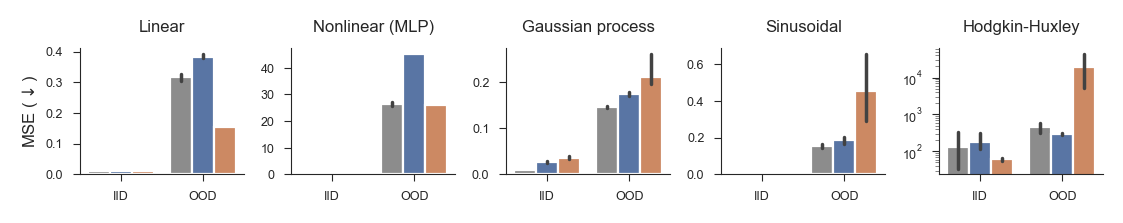

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(5.5, 1))

model_comparison_barplot(
    data=data_linreg,
    metrics=["val/iid_MSE", "val/wide_MSE"],
    metric_short_names={"val/iid_MSE": "IID", "val/wide_MSE": "OOD"},
    metric_units=r"MSE ($\downarrow$)",
    err_kws={"linewidth": 1.25},
    ax=axs[0],
)
axs[0].set(title="Linear")

model_comparison_barplot(
    data=data_mlpreg,
    metrics=["val/iid_MSE", "val/wide_MSE"],
    metric_short_names={"val/iid_MSE": "IID", "val/wide_MSE": "OOD"},
    metric_units=r"MSE ($\downarrow$)",
    err_kws={"linewidth": 1.25},
    ax=axs[1],
)
axs[1].set(title="Nonlinear (MLP)")

model_comparison_barplot(
    data=data_gpreg,
    metrics=["val/iid_MSE", "val/wide_MSE"],
    metric_short_names={"val/iid_MSE": "IID", "val/wide_MSE": "OOD"},
    metric_units=r"MSE ($\downarrow$)",
    err_kws={"linewidth": 1.25},
    ax=axs[2],
)
axs[2].set(title="Gaussian process")

model_comparison_barplot(
    data=data_sinreg,
    metrics=["val/iid_MSE", "val/wide_MSE"],
    metric_short_names={"val/iid_MSE": "IID", "val/wide_MSE": "OOD"},
    metric_units=r"MSE ($\downarrow$)",
    err_kws={"linewidth": 1.25},
    ax=axs[3],
)
axs[3].set(title="Sinusoidal")

model_comparison_barplot(
    data=data_huxley,
    metrics=["val/iid_MSE", "val/wide_MSE"],
    metric_short_names={"val/iid_MSE": "IID", "val/wide_MSE": "OOD"},
    metric_units=r"MSE ($\downarrow$)",
    err_kws={"linewidth": 1.25},
    ax=axs[4],
)
axs[4].set(title="Hodgkin-Huxley")
axs[4].set(yscale="log")

for ax in axs[1:]:
    ax.set(ylabel=None)
for ax in axs:
    ax.legend().remove()

fig.savefig("saved/regression_model_comparison.pdf")
plt.show()

# Classification model comparisons

### Collect data

In [6]:
# TODO: @Sangnie/Sarthak, fix to pull your data. I think just one setting (e.g., x_dim=10 or whatever) per dataset
# so that there isn't an overload of information in the main text. Elsewhere in the notebook we can generate plots
# showing more ablations if we wish.
data_lincls = get_run_performances(
    wandb_username="sarthmit",
    dataset="linear-classification",
    compare_across=["model"],
    comparison_metrics=[
        "val/Accuracy/dataloader_idx_0",
        "val/Accuracy/dataloader_idx_1",
        "val/Accuracy/dataloader_idx_2",
    ],
    mode="max",
    filters={
        "config.x_dim": 100,
        "config.y_dim": 10,
        "config.context_style": "same",
    },
    save_path=f"data/linear_classification_100_10_same.csv",
)
data_mlpcls = get_run_performances(
    wandb_username="sarthmit",
    dataset="mlp-classification",
    compare_across=["model"],
    comparison_metrics=[
        "val/Accuracy/dataloader_idx_0",
        "val/Accuracy/dataloader_idx_1",
        "val/Accuracy/dataloader_idx_2",
    ],
    mode="max",
    filters={
        "config.x_dim": 2,
        "config.y_dim": 10,
        "config.context_style": "same",
    },
    save_path=f"data/mlp_classification_2_10_same.csv",
)
data_alchemy = get_run_performances(
    wandb_username="leogagnon",
    wandb_project="mesa-opt-alchemy",
    dataset=None,
    compare_across="model",
    comparison_metrics=["val/acc"],
    mode="max",
    filters=None,
    save_path="data/alchemy_model_comparison.csv",
)

Loading from cached file data/linear_classification_100_10_same.csv...
Loading from cached file data/mlp_classification_2_10_same.csv...
Loading from cached file data/alchemy_model_comparison.csv...


### Plots

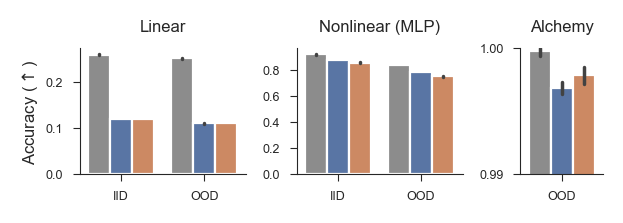

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(3, 1), width_ratios=[1, 1, 0.5])

model_comparison_barplot(
    data=data_lincls,
    metrics=["val/iid_Accuracy", "val/wide_Accuracy"],
    metric_short_names={"val/iid_Accuracy": "IID", "val/wide_Accuracy": "OOD"},
    metric_units=r"Accuracy ($\uparrow$)",
    err_kws={"linewidth": 1.25},
    ax=axs[0],
)
axs[0].set(title="Linear")

model_comparison_barplot(
    data=data_mlpcls,
    metrics=["val/iid_Accuracy", "val/wide_Accuracy"],
    metric_short_names={"val/iid_Accuracy": "IID", "val/wide_Accuracy": "OOD"},
    metric_units=r"Accuracy ($\uparrow$)",
    err_kws={"linewidth": 1.25},
    ax=axs[1],
)
axs[1].set(title="Nonlinear (MLP)")

model_comparison_barplot(
    data=data_alchemy,
    metrics=["val/acc"],
    metric_short_names={"val/acc": "OOD"},
    metric_units=r"Accuracy ($\uparrow$)",
    err_kws={"linewidth": 1.25},
    ax=axs[2],
)
axs[2].set(ylim=[0.99, 1.0], title="Alchemy", yticks=[0.99, 1.0])

for ax in axs[1:]:
    ax.set(ylabel=None)
for ax in axs:
    ax.legend().remove()

fig.savefig("saved/classification_model_comparison.pdf")
plt.show()

# Real-world model comparisons

### Collect data

In [7]:
data_raven = get_run_performances(
    wandb_username="ericelmoznino",
    dataset="raven",
    compare_across=["model"],
    comparison_metrics=["val_iid/accuracy", "val_ood/accuracy"],
    filters={
        "config.setting": "inpo",
        "tags": {
            "$nin": ["implicit_sweep", "explicit_tsf_sweep", "explicit_mlp_sweep"]
        },
    },
    save_path="data/raven_model_comparison.csv",
)
data_raven = data_raven[data_raven["model"] != "explicit-known"]
data_gene = get_run_performances(
    wandb_username="ericelmoznino",
    dataset="gene_crispr",
    compare_across=["model"],
    comparison_metrics=["val/R2"],
    filters={
        "config.model": {
            "$in": [
                "implicit-dropout",
                "explicit-transformer-dropoutcontext",
                "explicit-mlp",
            ]
        },
    },
    save_path="data/gene_model_comparison.csv",
)
data_gene["model"] = data_gene["model"].replace(
    {
        "implicit-dropout": "implicit",
        "explicit-transformer-dropoutcontext": "explicit-transformer",
    }
)

Loading from cached file data/raven_model_comparison.csv...
Loading from cached file data/gene_model_comparison.csv...


### Plots

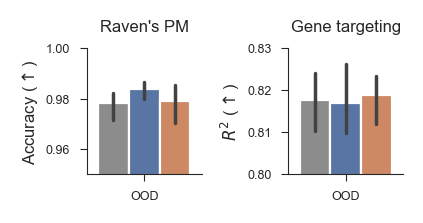

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2, 1))

model_comparison_barplot(
    data=data_raven,
    metrics=["val_ood/accuracy"],
    metric_short_names={"val_ood/accuracy": "OOD"},
    metric_units=r"Accuracy ($\uparrow$)",
    err_kws={"linewidth": 1.25},
    ax=axs[0],
)
axs[0].set(ylim=(0.95, 1.0), title="Raven's PM")

model_comparison_barplot(
    data=data_gene,
    metrics="val/R2",
    metric_short_names={"val/R2": "OOD"},
    metric_units=r"$R^2$ ($\uparrow$)",
    err_kws={"linewidth": 1.25},
    ax=axs[1],
)
axs[1].set(ylim=(0.8, 0.83), title="Gene targeting")

for ax in axs:
    ax.legend().remove()

fig.savefig("saved/real-world_model_comparison.pdf")
plt.show()

# Known predictor

Loading from cached file data/sinusoid_model_comparison.csv...
Loading from cached file data/raven_model_comparison.csv...


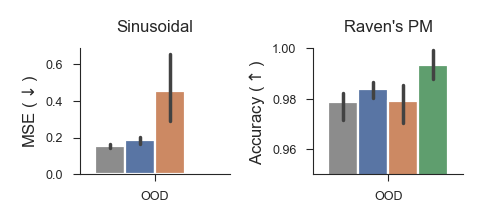

In [13]:
data_sinreg = get_run_performances(
    wandb_username="ericelmoznino",
    dataset="sinusoid-regression",
    compare_across=["model", "context_style"],
    comparison_metrics=["val/iid_MSE", "val/far_MSE", "val/wide_MSE"],
    mode="min",
    filters={
        "config.model": {"$nin": ["explicit-transformer-known-context"]},
        "config.kind_kwargs": "{'fixed_freq': True, 'n_freq': 3}",
    },
    save_path="data/sinusoid_model_comparison.csv",
)
data_sinreg = data_sinreg[data_sinreg["context_style"] == "same"]
data_raven = get_run_performances(
    wandb_username="ericelmoznino",
    dataset="raven",
    compare_across=["model"],
    comparison_metrics=["val_iid/accuracy", "val_ood/accuracy"],
    filters={
        "config.setting": "inpo",
        "tags": {
            "$nin": ["implicit_sweep", "explicit_tsf_sweep", "explicit_mlp_sweep"]
        },
    },
    save_path="data/raven_model_comparison.csv",
)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2.3, 1))

model_comparison_barplot(
    data=data_sinreg,
    metrics=["val/wide_MSE"],
    metric_short_names={"val/wide_MSE": "OOD"},
    metric_units=r"MSE ($\downarrow$)",
    err_kws={"linewidth": 1.25},
    ax=axs[0],
)
axs[0].set(title="Sinusoidal")

model_comparison_barplot(
    data=data_raven,
    metrics=["val_ood/accuracy"],
    metric_short_names={"val_ood/accuracy": "OOD"},
    metric_units=r"Accuracy ($\uparrow$)",
    err_kws={"linewidth": 1.25},
    ax=axs[1],
)
axs[1].set(ylim=(0.95, 1.0), title="Raven's PM")

for ax in axs:
    ax.legend().remove()

fig.savefig("saved/known_predictor.pdf")
plt.show()

# Interpretability

### Raven

Loading from cached file data/raven_rule_decoding.csv...


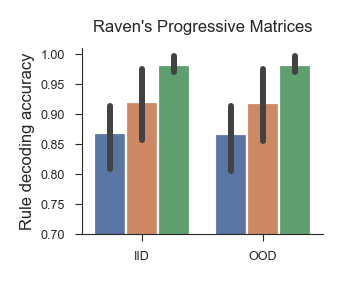

In [ ]:
data = get_run_performances(
    wandb_username="ericelmoznino",
    dataset="raven",
    compare_across=["model"],
    comparison_metrics=["val_iid/rule_accuracy", "val_ood/rule_accuracy"],
    filters={
        "config.setting": "inpo",
        "tags": {
            "$nin": ["implicit_sweep", "explicit_tsf_sweep", "explicit_mlp_sweep"]
        },
    },
    save_path="data/raven_rule_decoding.csv",
)

fig, ax = plt.subplots(figsize=(1.6, 1.3))
model_comparison_barplot(
    data=data,
    metrics=["val_iid/rule_accuracy", "val_ood/rule_accuracy"],
    metric_short_names={"val_iid/rule_accuracy": "IID", "val_ood/rule_accuracy": "OOD"},
    metric_units="Rule decoding accuracy",
    ax=ax,
)
ax.set(ylim=(0.7, 1.01), title="Raven's Progressive Matrices")
ax.legend(loc="upper right").remove()
fig.savefig("saved/raven_rule_decoding.pdf")
plt.show()

### CRISPR

Loading from cached file data/gene_target_decoding.csv...


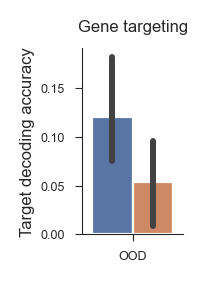

In [ ]:
data = get_run_performances(
    wandb_username="ericelmoznino",
    dataset="gene_crispr",
    compare_across=["model"],
    comparison_metrics=["val/ptb_id_acc"],
    filters={
        "config.model": {
            "$in": [
                "explicit-transformer-dropoutcontext",
                "explicit-mlp",
            ]
        },
    },
    save_path="data/gene_target_decoding.csv",
)
data["model"] = data["model"].replace(
    {"explicit-transformer-dropoutcontext": "explicit-transformer"}
)

fig, ax = plt.subplots(figsize=(0.9, 1.3))
model_comparison_barplot(
    data=data,
    metrics="val/ptb_id_acc",
    metric_short_names={"val/ptb_id_acc": "OOD"},
    metric_units="Target decoding accuracy",
    ax=ax,
)
ax.set(title="Gene targeting")
ax.legend(loc="upper right").remove()
fig.savefig("saved/gene_target_decoding.pdf")
plt.show()

### Sinusoidal regression

Loading from cached file data/sinusoid_w_decoding.csv...


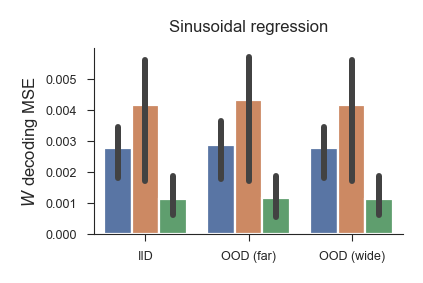

In [ ]:
data = get_run_performances(
    wandb_username="ericelmoznino",
    dataset="sinusoid-regression",
    compare_across=["model"],
    comparison_metrics=["val/iid_w_loss", "val/far_w_loss", "val/wide_w_loss"],
    mode="min",
    filters={
        "config.model": {"$nin": ["implicit", "explicit-transformer-known-context"]},
        "config.kind_kwargs": "{'fixed_freq': True, 'n_freq': 3}",
    },
    save_path="data/sinusoid_w_decoding.csv",
)

fig, ax = plt.subplots(figsize=(2, 1.3))
model_comparison_barplot(
    data=data,
    metrics=["val/iid_w_loss", "val/far_w_loss", "val/wide_w_loss"],
    metric_short_names={
        "val/iid_w_loss": "IID",
        "val/far_w_loss": "OOD (far)",
        "val/wide_w_loss": "OOD (wide)",
    },
    metric_units=r"$W$ decoding MSE",
    ax=ax,
)
ax.set(title="Sinusoidal regression")
ax.legend(loc="upper right").remove()
fig.savefig("saved/sinusoid_w_decoding.pdf")
plt.show()

---
# Appendix

### Gaussian Process

In [5]:
gp_data = {}
context_styles = ["same", "near"]
kernels = ["RBF", "Matern"]

for kernel in kernels:
    for context in context_styles:
        gp_data[f"{kernel} {context}"] = get_run_performances(
            wandb_username="sarthmit",
            dataset="gp-regression",
            compare_across=["model"],
            comparison_metrics=["val/iid_MSE", "val/far_MSE", "val/wide_MSE"],
            mode="min",
            filters={
                "config.model": {"$nin": ["explicit-transformer-known-context"]},
                "config.context_style": f"{context}",
                "config.kind_kwargs": "{'kernel':'" + str(kernel) + "'",
            },
            save_path=f"data/gp_regression_{kernel}_{context}.csv",
        )

Loading from cached file data/gp_regression_RBF_same.csv...
Loading from cached file data/gp_regression_RBF_near.csv...
Loading from cached file data/gp_regression_Matern_same.csv...
Loading from cached file data/gp_regression_Matern_near.csv...


/tmp/ipykernel_1049/1858205671.py:173: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.25}` instead.

  sns.barplot(
/tmp/ipykernel_1049/1858205671.py:173: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.25}` instead.

  sns.barplot(
/tmp/ipykernel_1049/1858205671.py:173: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.25}` instead.

  sns.barplot(
/tmp/ipykernel_1049/1858205671.py:173: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.25}` instead.

  sns.barplot(


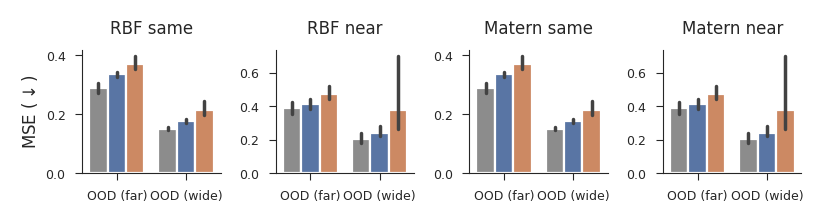

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(4, 1), width_ratios=[1, 1, 1, 1])

i = 0
for kernel in kernels:
    for context in context_styles:
        model_comparison_barplot(
            data=gp_data[f"{kernel} {context}"],
            metrics=["val/far_MSE", "val/wide_MSE"],
            metric_short_names={
                "val/far_MSE": "OOD (far)",
                "val/wide_MSE": "OOD (wide)",
            },
            metric_units=r"MSE ($\downarrow$)",
            err_kws={"linewidth": 1.25},
            ax=axs[i],
        )
        axs[i].set(title=f"{kernel} {context}")
        i += 1

for ax in axs[1:]:
    ax.set(ylabel=None)
for ax in axs:
    ax.legend().remove()
plt.show()

### Linear classification

In [7]:
linear_classification_data = {}

for x_dim in [2, 100]:
    for y_dim in [2, 10]:
        for context in context_styles:
            linear_classification_data[
                f"{x_dim} {y_dim} {context}"
            ] = get_run_performances(
                wandb_username="sarthmit",
                dataset="linear-classification",
                compare_across=["model"],
                comparison_metrics=[
                    "val/Accuracy/dataloader_idx_0",
                    "val/Accuracy/dataloader_idx_1",
                    "val/Accuracy/dataloader_idx_2",
                ],
                mode="max",
                filters={
                    "config.model": {"$nin": ["explicit-transformer-known-context"]},
                    "config.x_dim": x_dim,
                    "config.y_dim": y_dim,
                    "config.context_style": context,
                },
                save_path=f"data/linear_classification_{x_dim}_{y_dim}_{context}.csv",
            )

Loading from cached file data/linear_classification_2_2_same.csv...
Loading from cached file data/linear_classification_2_2_near.csv...
Loading from cached file data/linear_classification_2_10_same.csv...
Loading from cached file data/linear_classification_2_10_near.csv...
Loading from cached file data/linear_classification_100_2_same.csv...
Loading from cached file data/linear_classification_100_2_near.csv...
Loading from cached file data/linear_classification_100_10_same.csv...
Loading from cached file data/linear_classification_100_10_near.csv...


/tmp/ipykernel_1049/1858205671.py:173: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.25}` instead.

  sns.barplot(
/tmp/ipykernel_1049/1858205671.py:173: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.25}` instead.

  sns.barplot(
/tmp/ipykernel_1049/1858205671.py:173: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.25}` instead.

  sns.barplot(
/tmp/ipykernel_1049/1858205671.py:173: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.25}` instead.

  sns.barplot(
/tmp/ipykernel_1049/1858205671.py:173: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.25}` instead.

  sns.barplot(
/tmp/ipykernel_1049/1858205671.py:173: FutureWarning: 

The 

/tmp/ipykernel_1049/1858205671.py:173: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.25}` instead.

  sns.barplot(
/tmp/ipykernel_1049/1858205671.py:173: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.25}` instead.

  sns.barplot(


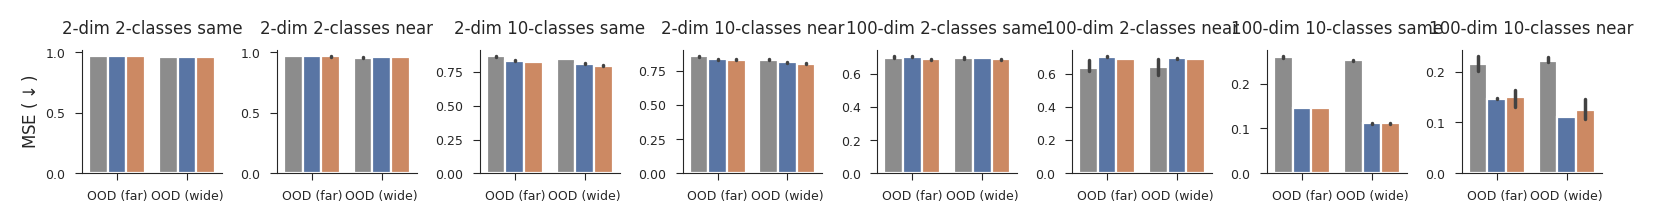

In [10]:
fig, axs = plt.subplots(
    nrows=1, ncols=8, figsize=(8, 1), width_ratios=[1, 1, 1, 1, 1, 1, 1, 1]
)

i = 0
for x_dim in [2, 100]:
    for y_dim in [2, 10]:
        for context in context_styles:
            model_comparison_barplot(
                data=linear_classification_data[f"{x_dim} {y_dim} {context}"],
                metrics=["val/far_Accuracy", "val/wide_Accuracy"],
                metric_short_names={
                    "val/far_Accuracy": "OOD (far)",
                    "val/wide_Accuracy": "OOD (wide)",
                },
                metric_units=r"MSE ($\downarrow$)",
                err_kws={"linewidth": 1.25},
                ax=axs[i],
            )
            axs[i].set(title=f"{x_dim}-dim {y_dim}-classes {context}")
            i += 1

for ax in axs[1:]:
    ax.set(ylabel=None)
for ax in axs:
    ax.legend().remove()
plt.show()

### MLP classification

In [13]:
mlp_classification_data = {}

for x_dim in [2, 100]:
    for y_dim in [2, 10]:
        for context in context_styles:
            mlp_classification_data[
                f"{x_dim} {y_dim} {context}"
            ] = get_run_performances(
                wandb_username="sarthmit",
                dataset="mlp-classification",
                compare_across=["model"],
                comparison_metrics=[
                    "val/Accuracy/dataloader_idx_0",
                    "val/Accuracy/dataloader_idx_1",
                    "val/Accuracy/dataloader_idx_2",
                ],
                mode="max",
                filters={
                    "config.model": {"$nin": ["explicit-transformer-known-context"]},
                    "config.x_dim": x_dim,
                    "config.y_dim": y_dim,
                    "config.context_style": context,
                },
                save_path=f"data/mlp_classification_{x_dim}_{y_dim}_{context}.csv",
            )

Loading from cached file data/mlp_classification_2_2_same.csv...
Loading from cached file data/mlp_classification_2_2_near.csv...
Loading from cached file data/mlp_classification_2_10_same.csv...
Loading from cached file data/mlp_classification_2_10_near.csv...
Loading from cached file data/mlp_classification_100_2_same.csv...
Loading from cached file data/mlp_classification_100_2_near.csv...
Loading from cached file data/mlp_classification_100_10_same.csv...
Loading from cached file data/mlp_classification_100_10_near.csv...


/tmp/ipykernel_1049/1858205671.py:173: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.25}` instead.

  sns.barplot(
/tmp/ipykernel_1049/1858205671.py:173: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.25}` instead.

  sns.barplot(
/tmp/ipykernel_1049/1858205671.py:173: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.25}` instead.

  sns.barplot(
/tmp/ipykernel_1049/1858205671.py:173: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.25}` instead.

  sns.barplot(
/tmp/ipykernel_1049/1858205671.py:173: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.25}` instead.

  sns.barplot(


/tmp/ipykernel_1049/1858205671.py:173: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.25}` instead.

  sns.barplot(
/tmp/ipykernel_1049/1858205671.py:173: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.25}` instead.

  sns.barplot(
/tmp/ipykernel_1049/1858205671.py:173: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.25}` instead.

  sns.barplot(


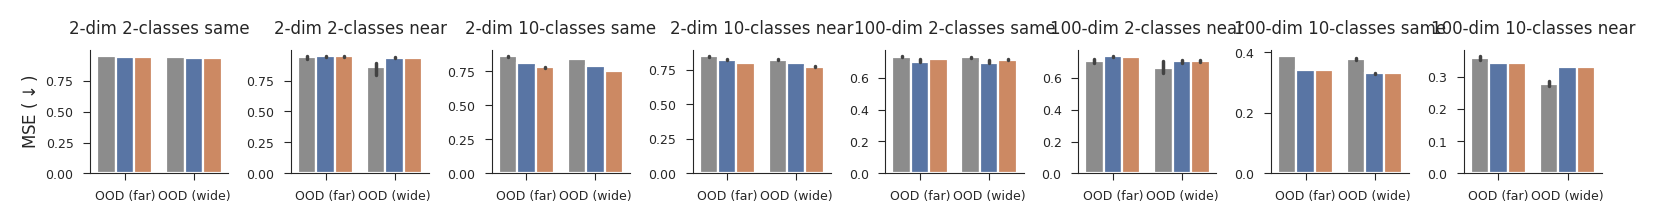

In [14]:
fig, axs = plt.subplots(
    nrows=1, ncols=8, figsize=(8, 1), width_ratios=[1, 1, 1, 1, 1, 1, 1, 1]
)

i = 0
for x_dim in [2, 100]:
    for y_dim in [2, 10]:
        for context in context_styles:
            model_comparison_barplot(
                data=mlp_classification_data[f"{x_dim} {y_dim} {context}"],
                metrics=["val/far_Accuracy", "val/wide_Accuracy"],
                metric_short_names={
                    "val/far_Accuracy": "OOD (far)",
                    "val/wide_Accuracy": "OOD (wide)",
                },
                metric_units=r"MSE ($\downarrow$)",
                err_kws={"linewidth": 1.25},
                ax=axs[i],
            )
            axs[i].set(title=f"{x_dim}-dim {y_dim}-classes {context}")
            i += 1

for ax in axs[1:]:
    ax.set(ylabel=None)
for ax in axs:
    ax.legend().remove()
plt.show()

### Linear Regression

In [ ]:
linear_regression_data = {}
context_styles = ["same", "near"]
for x_dim in [1, 100]:
    for context in context_styles:
        linear_regression_data[f"{x_dim} {context}"] = get_run_performances(
            wandb_username="sangnieb",
            dataset="linear-regression",
            compare_across=["model"],
            comparison_metrics=["val/iid_MSE", "val/far_MSE", "val/wide_MSE"],
            mode="min",
            filters={
                "config.model": {"$nin": ["explicit-transformer-known-context"]},
                "config.context_style": context,
                "config.x_dim": x_dim,
            },
            save_path=f"data/linreg_{x_dim}_{context}.csv",
            wandb_project="Explicit-Implicit-icml",
        )

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(4, 1), width_ratios=[1, 1, 1, 1])

i = 0
for x_dim in [1, 100]:
    for context in context_styles:
        model_comparison_barplot(
            data=linear_regression_data[f"{x_dim} {context}"],
            metrics=["val/far_MSE", "val/wide_MSE"],
            metric_short_names={
                "val/far_MSE": "OOD (far)",
                "val/wide_MSE": "OOD (wide)",
            },
            metric_units=r"MSE ($\downarrow$)",
            err_kws={"linewidth": 1.25},
            ax=axs[i],
        )
        axs[i].set(title=f"{x_dim}-dim {context}")
        i += 1

for ax in axs[1:]:
    ax.set(ylabel=None)
for ax in axs:
    ax.legend().remove()
plt.show()

In [ ]:
# MLP Regression

mlp_regression_data = {}
context_styles = ["same", "near"]
for x_dim in [1, 100]:
    for context in context_styles:
        mlp_regression_data[f"{x_dim} {context}"] = get_run_performances(
            wandb_username="sangnieb",
            dataset="mlp-regression",
            compare_across=["model"],
            comparison_metrics=["val/iid_MSE", "val/far_MSE", "val/wide_MSE"],
            mode="min",
            filters={
                "config.model": {"$nin": ["explicit-transformer-known-context"]},
                "config.context_style": context,
                "config.x_dim": x_dim,
            },
            save_path=f"data/nonlinreg_{x_dim}_{context}.csv",
            wandb_project="Explicit-Implicit-icml-nonlinear",
        )

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(4, 1), width_ratios=[1, 1, 1, 1])

i = 0
for x_dim in [1, 100]:
    for context in context_styles:
        model_comparison_barplot(
            data=mlp_regression_data[f"{x_dim} {context}"],
            metrics=["val/far_MSE", "val/wide_MSE"],
            metric_short_names={
                "val/far_MSE": "OOD (far)",
                "val/wide_MSE": "OOD (wide)",
            },
            metric_units=r"MSE ($\downarrow$)",
            err_kws={"linewidth": 1.25},
            ax=axs[i],
        )
        axs[i].set(title=f"{x_dim}-dim {context}")
        i += 1

for ax in axs[1:]:
    ax.set(ylabel=None)
for ax in axs:
    ax.legend().remove()
plt.show()

# Instructions

We pull data from the Weights & Biases API and generate plots. Plots can be combined together into a multi-panel figures manually in Keynote for best control over arrangement (see `notebooks/paper/figure_panels.key`). The documentation for the Weights & Biases API function that fetches runs can be found [here](https://docs.wandb.ai/ref/python/public-api/api#runs), but you shouldn't need it if you use the helper functions below.

In [1]:
from typing import Literal, Any
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import wandb

# Style for making nice-looking paper plots with page-scale figure size units
sns.set(
    style="ticks",
    context="paper",
    rc={
        "font.size": 5,
        "axes.titlesize": 6,
        "axes.labelsize": 6,
        "axes.labelpad": 2,
        "xtick.labelsize": 4.5,
        "ytick.labelsize": 4.5,
        "legend.title_fontsize": 4.5,
        "legend.fontsize": 4.5,
        "legend.markerscale": 0.5,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.4,
        "xtick.major.width": 0.4,
        "ytick.major.width": 0.4,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,
        "xtick.minor.size": 1.5,
        "ytick.minor.size": 1.5,
        "xtick.minor.width": 0.2,
        "ytick.minor.width": 0.2,
        "figure.constrained_layout.use": True,
        "figure.dpi": 200,
    },
)

api = wandb.Api()

# Helper functions

In [2]:
# API querying
def get_run_performances(
    wandb_username: str,
    dataset: str,
    compare_across: list[str],
    comparison_metrics: list[str],
    filters: dict[str, Any],
    best_epoch: bool = True,
    mode: Literal["min", "max"] = "max",
    group_comparison: Literal["mean", "median"] = "mean",
    save_path: str = None,
    wandb_project: str = "Explicit-Implicit",
) -> pd.DataFrame:
    """Pulls data from the W&B API and returns a dataframe with either the best epoch performance for each run
    (when `best_epoch=True`) or the entire training trajectory across runs (when `best_epoch=False`).

    Args:
        wandb_username (str): Your W&B username.
        dataset (str): The identity of the task dataset you're querying (specified in the experiment config).
        compare_across (list[str]): List of attributes you want to compare across (e.g., ["model", "x_dim"]). Runs that have the same values for these attributes will be averaged over (hopefully just the seed!). These attributes are things that show up in the W&B config.
        comparison_metrics (list[str]): Metrics that you want to compare across runs. These are W&B metric names. Note that the first metric in the list is used for selecting the best epoch.
        filters (dict[str, Any]): W&B API filters used to select only a subset of runs. See code below for examples.
        best_epoch (bool, optional): Whether to select metrics only at the best epoch of each run, or return the entire training trajectory. Defaults to `True`.
        mode (Literal[&quot;min&quot;, &quot;max&quot;], optional): Whether smaller values are better for the metric (e.g., MSE) or larger values are (e.g., accuracy). Defaults to `"max"`.
        group_comparison (Literal[&quot;mean&quot;, &quot;median&quot;], optional): How to aggregate metrics within groups (e.g., across seeds for a given model) in order to pick the best epoch. Defaults to `"mean"`.
        save_path (str, optional): Optionally save the resulting dataframe. Note that if the file already exists, we retrieve its data and return that rather than querying the API. Defaults to `None`.
        wandb_project (str, optional): Name of the W&B project that the runs are in. Defaults to `"Explicit-Implicit"`.

    Returns:
        pd.DataFrame: Dataframe of results. It contains the run id, the `compare_across` values, the `comparison_metrics` metrics, and the epoch.
    """
    # If data has already been downloaded, don't make another API call
    if os.path.exists(save_path):
        print(f"Loading from cached file {save_path}...")
        data = pd.read_csv(save_path)
        data.replace("imlicit", "implicit", inplace=True)
        if "val/Accuracy/dataloader_idx_0" in list(data.columns.values):
            data["val/iid_Accuracy"] = data["val/Accuracy/dataloader_idx_0"]
            data["val/far_Accuracy"] = data["val/Accuracy/dataloader_idx_1"]
            data["val/wide_Accuracy"] = data["val/Accuracy/dataloader_idx_2"]
        return data

    if wandb_project == "mesa-opt-alchemy":
        alchemy_models = {
            "implicit": ["3udju5nr", "62rdiupe", "jk9sk4lq"],
            "explicit-transformer": ["qplfaq96", "zb3y9jca", "hhovr0xq"],
            "explicit-mlp": ["0xucpplr", "p9h6phu6", "79vvovut"],
        }
        data = []
        for model in alchemy_models.keys():
            runs = wandb.Api().runs(
                "leogagnon/mesa-opt-alchemy",
                filters={"name": {"$in": alchemy_models[model]}},
            )  # name instead of ID
            for run in runs:
                run_data = run.history(
                    samples=2000, x_axis="epoch", keys=comparison_metrics
                )
                run_data = run_data.assign(model=model)
                data.append(run_data)
        data = pd.concat(data)
    else:
        # Fetch all run data from the API
        runs = api.runs(
            f"{wandb_username}/{wandb_project}",
            filters={"config.dataset": dataset, **filters},
        )

        # Collect all of the run histories into a dataframe
        data = []
        for run in runs:
            comparison_vals = {k: run.config[k] for k in compare_across}
            run_data = run.history(
                samples=1000000, x_axis="epoch", keys=comparison_metrics
            )
            run_data = run_data.assign(run_id=run.id, **comparison_vals)
            data.append(run_data)
        data = pd.concat(data)

    # For each candidate, find the best performance over the course of training.
    # If there are multiple runs with the same `compare_across` values (e.g., different seeds),
    # then we take the best aggregate performance.
    if best_epoch:
        # fmt: off
        def best_epoch_results(group_data):
            epoch_agg = group_data.groupby("epoch")[comparison_metrics[0]].agg(group_comparison)
            best_epoch = epoch_agg.argmax() if mode == "max" else epoch_agg.argmin()
            best_epoch_data = group_data[group_data["epoch"] == best_epoch]
            return best_epoch_data
        data = data.groupby(compare_across).apply(best_epoch_results)
        data = data.reset_index(drop=True)
        # fmt: on

    data = data[["run_id", "epoch"] + compare_across + comparison_metrics]
    if save_path is not None:
        data.to_csv(save_path, index=False)
    return data


# Plotting


default_model_order = [
    "implicit",
    "explicit-transformer",
    "explicit-mlp",
    "explicit-known",
]
default_model_colours = {
    "implicit": sns.color_palette()[7],
    "explicit-transformer": sns.color_palette()[0],
    "explicit-mlp": sns.color_palette()[1],
    "explicit-known": sns.color_palette()[2],
}
default_model_short_names = {
    "implicit": "Implicit",
    "explicit-transformer": "Explicit - Transformer",
    "explicit-mlp": "Explicit - MLP",
    "explicit-known": "Explicit - Known",
}


def model_comparison_barplot(
    data: pd.DataFrame,
    metrics: str | list[str],
    metric_short_names: dict[str, str],
    metric_units: str,
    ax: plt.Axes,
    model_order: list[str] = default_model_order,
    model_colours: dict[str, Any] = default_model_colours,
    model_short_names: dict[str, str] = default_model_short_names,
    errorbar: str = "minmax",
    **kwargs,
) -> plt.Axes:
    """Convenience function to generate a barplot comparing models on a set of metrics. Metrics correspond to x-ticks, models correspond to bar colours.

    Args:
        data (pd.DataFrame): Dataframe of model performances, generally obtained from `get_run_performances()`.
        metrics (str | list[str]): Metrics along which to compare models. These will be x-ticks in the barplot.
        metric_short_names (dict[str, str]): Mapping from raw metric names to desired display names in the plot.
        metric_units (str): Units of the metrics, to be displayed on the y-axis.
        ax (plt.Axes): Matplotlib axes on which to plot.
        model_order (list[str], optional): Order in which to display models along the x-axis. Defaults to `default_model_order`.
        model_colours (dict[str, Any], optional): Colour for each model's bar. Defaults to `default_model_colours`.
        model_short_names (dict[str, str], optional): Display names for models in the legend. Defaults to `default_model_short_names`.
        errorbar (str, optional): How to construct the error bars when there are several samples per model and metric. Defaults to `"minmax"`.

    Returns:
        plt.Axes: The axes on which the plot was made.
    """
    # Check argument correctness
    models = data["model"].unique()
    for m in models:
        assert m in model_order and m in model_colours and m in model_short_names
    model_order = [m for m in model_order if m in models]
    if isinstance(metrics, str):
        metrics = [metrics]
    errorbar = (lambda x: (x.min(), x.max())) if errorbar == "minmax" else errorbar

    # Reorganize data
    data = data.rename(columns={m: metric_short_names[m] for m in metrics})
    data["model"] = data["model"].map(model_short_names)
    model_colours = [model_colours[m] for m in model_order]
    model_order = [model_short_names[m] for m in model_order]
    data = data.melt(
        id_vars=["model"],
        value_vars=metric_short_names.values(),
        var_name="metric",
        value_name=metric_units,
    )

    # Make the plot
    sns.barplot(
        data=data,
        ax=ax,
        x="metric",
        y=metric_units,
        hue="model",
        hue_order=model_order,
        palette=model_colours,
        errorbar=errorbar,
        **kwargs,
    )
    ax.set(xlabel="")
    ax.legend()

    return ax

# Regression model comparisons

### Collect data

In [3]:
# TODO: @Sangnie/Sarthak, fix to pull your data. I think just one setting (e.g., x_dim=10 or whatever) per dataset
# so that there isn't an overload of information in the main text. Elsewhere in the notebook we can generate plots
# showing more ablations if we wish.
data_linreg = get_run_performances(
    wandb_username="ericelmoznino",
    dataset="sinusoid-regression",
    compare_across=["model"],
    comparison_metrics=["val/iid_MSE", "val/far_MSE", "val/wide_MSE"],
    mode="min",
    filters={
        "config.model": {"$nin": ["explicit-transformer-known-context"]},
        "config.context_style": "same",
        "config.kind_kwargs": "{'fixed_freq': True, 'n_freq': 3}",
    },
    save_path="data/temp.csv",
)
data_mlpreg = get_run_performances(
    wandb_username="ericelmoznino",
    dataset="sinusoid-regression",
    compare_across=["model"],
    comparison_metrics=["val/iid_MSE", "val/far_MSE", "val/wide_MSE"],
    mode="min",
    filters={
        "config.model": {"$nin": ["explicit-transformer-known-context"]},
        "config.context_style": "same",
        "config.kind_kwargs": "{'fixed_freq': True, 'n_freq': 3}",
    },
    save_path="data/temp.csv",
)
data_gpreg = get_run_performances(
    wandb_username="sarthmit",
    dataset="gp-regression",
    compare_across=["model"],
    comparison_metrics=["val/iid_MSE", "val/far_MSE", "val/wide_MSE"],
    mode="min",
    filters={
        "config.context_style": "same",
        "config.kind_kwargs": "{'kernel': 'RBF'}",
    },
    save_path="data/gp_regression.csv",
)
data_sinreg = get_run_performances(
    wandb_username="ericelmoznino",
    dataset="sinusoid-regression",
    compare_across=["model", "context_style"],
    comparison_metrics=["val/iid_MSE", "val/far_MSE", "val/wide_MSE"],
    mode="min",
    filters={
        "config.model": {"$nin": ["explicit-transformer-known-context"]},
        "config.kind_kwargs": "{'fixed_freq': True, 'n_freq': 3}",
    },
    save_path="data/sinusoid_model_comparison.csv",
)
data_sinreg = data_sinreg[data_sinreg["context_style"] == "same"]
data_huxley = get_run_performances(
    wandb_username="leogagnon",
    dataset="hh-regression",
    compare_across=["model"],
    comparison_metrics=["val/iid_MSE", "val/far_MSE", "val/wide_MSE"],
    mode="min",
    filters={
        "tags": {"$in": ["bad_plot"]},
    },
    save_path="data/hh_model_comparison.csv",
)

Loading from cached file data/temp.csv...
Loading from cached file data/temp.csv...
Loading from cached file data/gp_regression.csv...
Loading from cached file data/sinusoid_model_comparison.csv...
Loading from cached file data/hh_model_comparison.csv...


### Plots

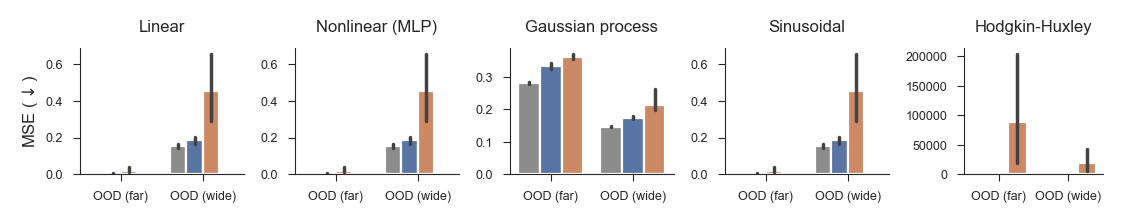

In [4]:
fig, axs = plt.subplots(
    nrows=1, ncols=5, figsize=(5.5, 1), width_ratios=[1, 1, 1, 1, 0.85]
)

model_comparison_barplot(
    data=data_linreg,
    metrics=["val/far_MSE", "val/wide_MSE"],
    metric_short_names={"val/far_MSE": "OOD (far)", "val/wide_MSE": "OOD (wide)"},
    metric_units=r"MSE ($\downarrow$)",
    err_kws={"linewidth": 1.25},
    ax=axs[0],
)
axs[0].set(title="Linear")

model_comparison_barplot(
    data=data_mlpreg,
    metrics=["val/far_MSE", "val/wide_MSE"],
    metric_short_names={"val/far_MSE": "OOD (far)", "val/wide_MSE": "OOD (wide)"},
    metric_units=r"MSE ($\downarrow$)",
    err_kws={"linewidth": 1.25},
    ax=axs[1],
)
axs[1].set(title="Nonlinear (MLP)")

model_comparison_barplot(
    data=data_gpreg,
    metrics=["val/far_MSE", "val/wide_MSE"],
    metric_short_names={"val/far_MSE": "OOD (far)", "val/wide_MSE": "OOD (wide)"},
    metric_units=r"MSE ($\downarrow$)",
    err_kws={"linewidth": 1.25},
    ax=axs[2],
)
axs[2].set(title="Gaussian process")

model_comparison_barplot(
    data=data_sinreg,
    metrics=["val/far_MSE", "val/wide_MSE"],
    metric_short_names={"val/far_MSE": "OOD (far)", "val/wide_MSE": "OOD (wide)"},
    metric_units=r"MSE ($\downarrow$)",
    err_kws={"linewidth": 1.25},
    ax=axs[3],
)
axs[3].set(title="Sinusoidal")

model_comparison_barplot(
    data=data_huxley,
    metrics=["val/far_MSE", "val/wide_MSE"],
    metric_short_names={"val/far_MSE": "OOD (far)", "val/wide_MSE": "OOD (wide)"},
    metric_units=r"MSE ($\downarrow$)",
    err_kws={"linewidth": 1.25},
    ax=axs[4],
)
axs[4].set(title="Hodgkin-Huxley")

for ax in axs[1:]:
    ax.set(ylabel=None)
for ax in axs:
    ax.legend().remove()

fig.savefig("saved/regression_model_comparison.pdf")
plt.show()

# Classification model comparisons

### Collect data

In [19]:
# TODO: @Sangnie/Sarthak, fix to pull your data. I think just one setting (e.g., x_dim=10 or whatever) per dataset
# so that there isn't an overload of information in the main text. Elsewhere in the notebook we can generate plots
# showing more ablations if we wish.
data_lincls = get_run_performances(
    wandb_username="sarthmit",
    dataset="linear-classification",
    compare_across=["model"],
    comparison_metrics=[
        "val/Accuracy/dataloader_idx_0",
        "val/Accuracy/dataloader_idx_1",
        "val/Accuracy/dataloader_idx_2",
    ],
    mode="max",
    filters={
        "config.x_dim": 100,
        "config.y_dim": 10,
        "config.context_style": "same",
    },
    save_path=f"data/linear_classification_100_10_same.csv",
)
data_mlpcls = get_run_performances(
    wandb_username="sarthmit",
    dataset="mlp-classification",
    compare_across=["model"],
    comparison_metrics=[
        "val/Accuracy/dataloader_idx_0",
        "val/Accuracy/dataloader_idx_1",
        "val/Accuracy/dataloader_idx_2",
    ],
    mode="max",
    filters={
        "config.x_dim": 2,
        "config.y_dim": 10,
        "config.context_style": "same",
    },
    save_path=f"data/mlp_classification_2_10_same.csv",
)
data_alchemy = get_run_performances(
    wandb_username="leogagnon",
    wandb_project="mesa-opt-alchemy",
    dataset=None,
    compare_across="model",
    comparison_metrics=["val/acc"],
    mode="max",
    filters=None,
    save_path="data/alchemy_model_comparison.csv",
)

Loading from cached file data/linear_classification_100_10_same.csv...
Loading from cached file data/mlp_classification_2_10_same.csv...
Loading from cached file data/alchemy_model_comparison.csv...


### Plots

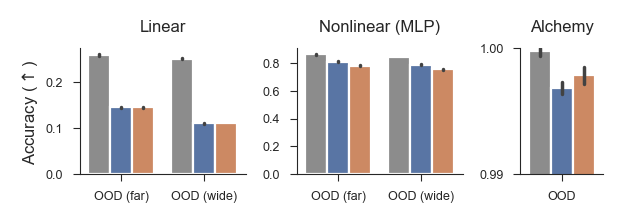

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(3, 1), width_ratios=[1, 1, 0.5])

model_comparison_barplot(
    data=data_lincls,
    metrics=["val/far_Accuracy", "val/wide_Accuracy"],
    metric_short_names={
        "val/far_Accuracy": "OOD (far)",
        "val/wide_Accuracy": "OOD (wide)",
    },
    metric_units=r"Accuracy ($\uparrow$)",
    err_kws={"linewidth": 1.25},
    ax=axs[0],
)
axs[0].set(title="Linear")

model_comparison_barplot(
    data=data_mlpcls,
    metrics=["val/far_Accuracy", "val/wide_Accuracy"],
    metric_short_names={
        "val/far_Accuracy": "OOD (far)",
        "val/wide_Accuracy": "OOD (wide)",
    },
    metric_units=r"Accuracy ($\uparrow$)",
    err_kws={"linewidth": 1.25},
    ax=axs[1],
)
axs[1].set(title="Nonlinear (MLP)")

model_comparison_barplot(
    data=data_alchemy,
    metrics=["val/acc"],
    metric_short_names={"val/acc": "OOD"},
    metric_units=r"Accuracy ($\uparrow$)",
    err_kws={"linewidth": 1.25},
    ax=axs[2],
)
axs[2].set(ylim=[0.99, 1.0], title="Alchemy", yticks=[0.99, 1.0])

for ax in axs[1:]:
    ax.set(ylabel=None)
for ax in axs:
    ax.legend().remove()

fig.savefig("saved/classification_model_comparison.pdf")
plt.show()

# Real-world model comparisons

### Collect data

In [ ]:
data_raven = get_run_performances(
    wandb_username="ericelmoznino",
    dataset="raven",
    compare_across=["model"],
    comparison_metrics=["val_iid/accuracy", "val_ood/accuracy"],
    filters={
        "config.setting": "inpo",
        "tags": {
            "$nin": ["implicit_sweep", "explicit_tsf_sweep", "explicit_mlp_sweep"]
        },
    },
    save_path="data/raven_model_comparison.csv",
)
data_gene = get_run_performances(
    wandb_username="ericelmoznino",
    dataset="gene_crispr",
    compare_across=["model"],
    comparison_metrics=["val/R2"],
    filters={
        "config.model": {
            "$in": [
                "implicit-dropout",
                "explicit-transformer-dropoutcontext",
                "explicit-mlp",
            ]
        },
    },
    save_path="data/gene_model_comparison.csv",
)
data_gene["model"] = data_gene["model"].replace(
    {
        "implicit-dropout": "implicit",
        "explicit-transformer-dropoutcontext": "explicit-transformer",
    }
)

Loading from cached file data/raven_model_comparison.csv...
Loading from cached file data/gene_model_comparison.csv...


### Plots

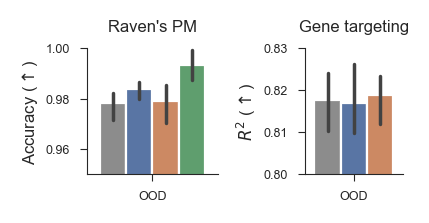

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2, 1), width_ratios=[4, 3])

model_comparison_barplot(
    data=data_raven,
    metrics=["val_ood/accuracy"],
    metric_short_names={"val_ood/accuracy": "OOD"},
    metric_units=r"Accuracy ($\uparrow$)",
    err_kws={"linewidth": 1.25},
    ax=axs[0],
)
axs[0].set(ylim=(0.95, 1.0), title="Raven's PM")

model_comparison_barplot(
    data=data_gene,
    metrics="val/R2",
    metric_short_names={"val/R2": "OOD"},
    metric_units=r"$R^2$ ($\uparrow$)",
    err_kws={"linewidth": 1.25},
    ax=axs[1],
)
axs[1].set(ylim=(0.8, 0.83), title="Gene targeting")

for ax in axs:
    ax.legend().remove()

fig.savefig("saved/real-world_model_comparison.pdf")
plt.show()

# Interpretability

Loading from cached file data/sinusoid_w_decoding.csv...
Loading from cached file data/raven_rule_decoding.csv...
Loading from cached file data/gene_target_decoding.csv...


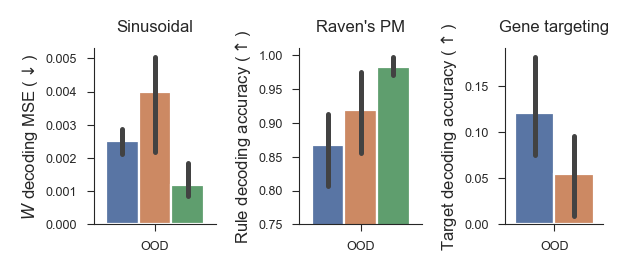

In [33]:
data_sinreg = get_run_performances(
    wandb_username="ericelmoznino",
    dataset="sinusoid-regression",
    compare_across=["model", "context_style"],
    comparison_metrics=["val/iid_w_loss", "val/far_w_loss", "val/wide_w_loss"],
    mode="min",
    filters={
        "config.model": {"$nin": ["implicit", "explicit-transformer-known-context"]},
        "config.kind_kwargs": "{'fixed_freq': True, 'n_freq': 3}",
    },
    save_path="data/sinusoid_w_decoding.csv",
)
data_sinreg = data_sinreg[data_sinreg["context_style"] == "same"]
data_raven = get_run_performances(
    wandb_username="ericelmoznino",
    dataset="raven",
    compare_across=["model"],
    comparison_metrics=["val_iid/rule_accuracy", "val_ood/rule_accuracy"],
    filters={
        "config.setting": "inpo",
        "tags": {
            "$nin": ["implicit_sweep", "explicit_tsf_sweep", "explicit_mlp_sweep"]
        },
    },
    save_path="data/raven_rule_decoding.csv",
)
data_gene = get_run_performances(
    wandb_username="ericelmoznino",
    dataset="gene_crispr",
    compare_across=["model"],
    comparison_metrics=["val/ptb_id_acc"],
    filters={
        "config.model": {
            "$in": [
                "explicit-transformer-dropoutcontext",
                "explicit-mlp",
            ]
        },
    },
    save_path="data/gene_target_decoding.csv",
)
data_gene["model"] = data_gene["model"].replace(
    {"explicit-transformer-dropoutcontext": "explicit-transformer"}
)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(3, 1.25), width_ratios=[1, 1, 0.8])

model_comparison_barplot(
    data=data_sinreg,
    metrics=["val/wide_w_loss"],
    metric_short_names={
        "val/wide_w_loss": "OOD"
    },
    metric_units=r"$W$ decoding MSE ($\downarrow$)",
    ax=axs[0],
)
axs[0].set(title="Sinusoidal")

model_comparison_barplot(
    data=data_raven,
    metrics=["val_ood/rule_accuracy"],
    metric_short_names={"val_ood/rule_accuracy": "OOD"},
    metric_units=r"Rule decoding accuracy ($\uparrow$)",
    ax=axs[1],
)
axs[1].set(ylim=(0.75, 1.01), title="Raven's PM")

model_comparison_barplot(
    data=data_gene,
    metrics="val/ptb_id_acc",
    metric_short_names={"val/ptb_id_acc": "OOD"},
    metric_units=r"Target decoding accuracy ($\uparrow$)",
    ax=axs[2],
)
axs[2].set(title="Gene targeting")

for ax in axs:
    ax.legend().remove()

fig.savefig("saved/interpretability_decoding.pdf")
plt.show()

---
# Appendix

### Gaussian Process

In [15]:
gp_data = {}
context_styles = ["same", "near"]
kernels = ["RBF", "Matern"]

for kernel in kernels:
    for context in context_styles:
        gp_data[f"{kernel} {context}"] = get_run_performances(
            wandb_username="sarthmit",
            dataset="gp-regression",
            compare_across=["model"],
            comparison_metrics=["val/iid_MSE", "val/far_MSE", "val/wide_MSE"],
            mode="min",
            filters={
                "config.model": {"$nin": ["explicit-transformer-known-context"]},
                "config.context_style": f"{context}",
                "config.kind_kwargs": "{'kernel':'" + str(kernel) + "'",
            },
            save_path=f"data/gp_regression_{kernel}_{context}.csv",
        )

Loading from cached file data/gp_regression_RBF_same.csv...
Loading from cached file data/gp_regression_RBF_near.csv...
Loading from cached file data/gp_regression_Matern_same.csv...
Loading from cached file data/gp_regression_Matern_near.csv...


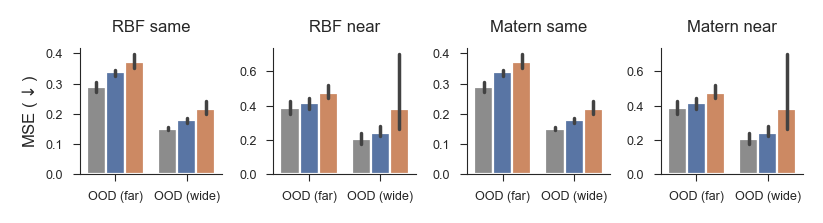

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(4, 1), width_ratios=[1, 1, 1, 1])

i = 0
for kernel in kernels:
    for context in context_styles:
        model_comparison_barplot(
            data=gp_data[f"{kernel} {context}"],
            metrics=["val/far_MSE", "val/wide_MSE"],
            metric_short_names={
                "val/far_MSE": "OOD (far)",
                "val/wide_MSE": "OOD (wide)",
            },
            metric_units=r"MSE ($\downarrow$)",
            err_kws={"linewidth": 1.25},
            ax=axs[i],
        )
        axs[i].set(title=f"{kernel} {context}")
        i += 1

for ax in axs[1:]:
    ax.set(ylabel=None)
for ax in axs:
    ax.legend().remove()
plt.show()

### Linear classification

In [17]:
linear_classification_data = {}

for x_dim in [2, 100]:
    for y_dim in [2, 10]:
        for context in context_styles:
            linear_classification_data[
                f"{x_dim} {y_dim} {context}"
            ] = get_run_performances(
                wandb_username="sarthmit",
                dataset="linear-classification",
                compare_across=["model"],
                comparison_metrics=[
                    "val/Accuracy/dataloader_idx_0",
                    "val/Accuracy/dataloader_idx_1",
                    "val/Accuracy/dataloader_idx_2",
                ],
                mode="max",
                filters={
                    "config.model": {"$nin": ["explicit-transformer-known-context"]},
                    "config.x_dim": x_dim,
                    "config.y_dim": y_dim,
                    "config.context_style": context,
                },
                save_path=f"data/linear_classification_{x_dim}_{y_dim}_{context}.csv",
            )

Loading from cached file data/linear_classification_2_2_same.csv...
Loading from cached file data/linear_classification_2_2_near.csv...
Loading from cached file data/linear_classification_2_10_same.csv...
Loading from cached file data/linear_classification_2_10_near.csv...
Loading from cached file data/linear_classification_100_2_same.csv...
Loading from cached file data/linear_classification_100_2_near.csv...
Loading from cached file data/linear_classification_100_10_same.csv...
Loading from cached file data/linear_classification_100_10_near.csv...


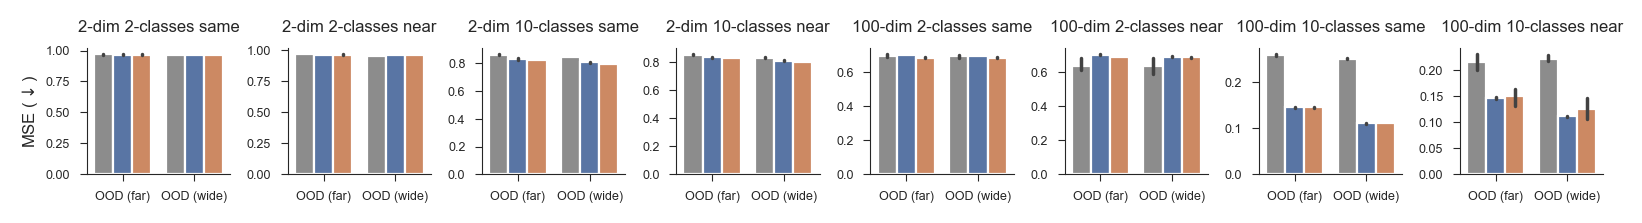

In [18]:
fig, axs = plt.subplots(
    nrows=1, ncols=8, figsize=(8, 1), width_ratios=[1, 1, 1, 1, 1, 1, 1, 1]
)

i = 0
for x_dim in [2, 100]:
    for y_dim in [2, 10]:
        for context in context_styles:
            model_comparison_barplot(
                data=linear_classification_data[f"{x_dim} {y_dim} {context}"],
                metrics=["val/far_Accuracy", "val/wide_Accuracy"],
                metric_short_names={
                    "val/far_Accuracy": "OOD (far)",
                    "val/wide_Accuracy": "OOD (wide)",
                },
                metric_units=r"MSE ($\downarrow$)",
                err_kws={"linewidth": 1.25},
                ax=axs[i],
            )
            axs[i].set(title=f"{x_dim}-dim {y_dim}-classes {context}")
            i += 1

for ax in axs[1:]:
    ax.set(ylabel=None)
for ax in axs:
    ax.legend().remove()
plt.show()

### MLP classification

In [19]:
mlp_classification_data = {}

for x_dim in [2, 100]:
    for y_dim in [2, 10]:
        for context in context_styles:
            mlp_classification_data[
                f"{x_dim} {y_dim} {context}"
            ] = get_run_performances(
                wandb_username="sarthmit",
                dataset="mlp-classification",
                compare_across=["model"],
                comparison_metrics=[
                    "val/Accuracy/dataloader_idx_0",
                    "val/Accuracy/dataloader_idx_1",
                    "val/Accuracy/dataloader_idx_2",
                ],
                mode="max",
                filters={
                    "config.model": {"$nin": ["explicit-transformer-known-context"]},
                    "config.x_dim": x_dim,
                    "config.y_dim": y_dim,
                    "config.context_style": context,
                },
                save_path=f"data/mlp_classification_{x_dim}_{y_dim}_{context}.csv",
            )

Loading from cached file data/mlp_classification_2_2_same.csv...
Loading from cached file data/mlp_classification_2_2_near.csv...
Loading from cached file data/mlp_classification_2_10_same.csv...
Loading from cached file data/mlp_classification_2_10_near.csv...
Loading from cached file data/mlp_classification_100_2_same.csv...
Loading from cached file data/mlp_classification_100_2_near.csv...
Loading from cached file data/mlp_classification_100_10_same.csv...
Loading from cached file data/mlp_classification_100_10_near.csv...


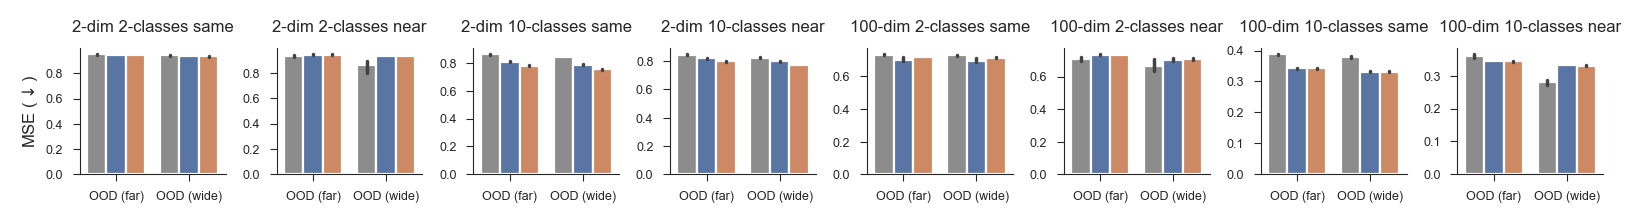

In [20]:
fig, axs = plt.subplots(
    nrows=1, ncols=8, figsize=(8, 1), width_ratios=[1, 1, 1, 1, 1, 1, 1, 1]
)

i = 0
for x_dim in [2, 100]:
    for y_dim in [2, 10]:
        for context in context_styles:
            model_comparison_barplot(
                data=mlp_classification_data[f"{x_dim} {y_dim} {context}"],
                metrics=["val/far_Accuracy", "val/wide_Accuracy"],
                metric_short_names={
                    "val/far_Accuracy": "OOD (far)",
                    "val/wide_Accuracy": "OOD (wide)",
                },
                metric_units=r"MSE ($\downarrow$)",
                err_kws={"linewidth": 1.25},
                ax=axs[i],
            )
            axs[i].set(title=f"{x_dim}-dim {y_dim}-classes {context}")
            i += 1

for ax in axs[1:]:
    ax.set(ylabel=None)
for ax in axs:
    ax.legend().remove()
plt.show()

### Decoder is the problem - sinusoidal regression

Loading from cached file data/decoder_problem.csv...


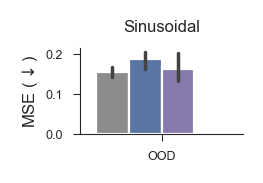

In [10]:
data = get_run_performances(
    wandb_username="ericelmoznino",
    dataset="sinusoid-regression",
    compare_across=["model", "context_style"],
    comparison_metrics=["val/iid_MSE", "val/far_MSE", "val/wide_MSE"],
    mode="min",
    filters={
        "config.model": {"$nin": ["explicit-mlp"]},
        "config.kind_kwargs": "{'fixed_freq': True, 'n_freq': 3}",
    },
    save_path="data/decoder_problem.csv",
)
data = data[data["context_style"] == "same"]

fig, ax = plt.subplots(figsize=(1.2, 0.8))

model_order = [
    "implicit",
    "explicit-transformer",
    "explicit-mlp",
    "explicit-known",
]
default_model_colours = {
    "implicit": sns.color_palette()[7],
    "explicit-transformer": sns.color_palette()[0],
    "explicit-mlp": sns.color_palette()[1],
    "explicit-known": sns.color_palette()[2],
}
default_model_short_names = {
    "implicit": "Implicit",
    "explicit-transformer": "Explicit - Transformer",
    "explicit-mlp": "Explicit - MLP",
    "explicit-known": "Explicit - Known",
}

model_comparison_barplot(
    data=data,
    metrics=["val/wide_MSE"],
    metric_short_names={"val/wide_MSE": "OOD"},
    metric_units=r"MSE ($\downarrow$)",
    err_kws={"linewidth": 1.25},
    ax=ax,
    model_order=default_model_order[:-1]
    + ["explicit-transformer-known-context"]
    + default_model_order[-1:],
    model_colours={
        "explicit-transformer-known-context": sns.color_palette()[4],
        **default_model_colours,
    },
    model_short_names={
        "explicit-transformer-known-context": "Explicit - Known context",
        **default_model_short_names,
    },
)
ax.set(title="Sinusoidal")
ax.legend().remove()

fig.savefig("saved/decoder_problem.pdf")
plt.show()